# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [38]:
DATA_DIR = '/data'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

## Download and extract files

In [39]:
import os.path
from os import path

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
  if path.exists(pth) == False:
    os.mkdir(pth)

FileNotFoundError: [Errno 2] No such file or directory: '/data/train'

In [ ]:
#only run this cell once, at the start
import requests, os

train_zip = "train.zip"
test_zip = "test.zip"
sample_sub = "SampleSubmission.csv"

In [ ]:
!unzip "/content/train/train.zip" -d "/content/train/"
!unzip "/content/test/test.zip" -d "/content/test/"

# Data Prep

## Import Libraries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
#import lightgbm
#from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')

# Modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier #Stohastic gradient descent
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [3]:
!pip install lightgbm

  Using cached lightgbm-4.3.0.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.3.0-py3-none-macosx_13_0_arm64.whl size=1350056 sha256=294fef199352e0e603f4aaec7c2861344b36c0cc4bde014204d01ce717a187e8
  Stored in directory: /Users/milamiletic/Library/Caches/pip/wheels/f4/d1/f4/3cd66516e5a05b0879846879dfb06e5a087f453adb405a5999
Successfully built lightgbm


In [5]:
from os import path
import sys
sys.path.append(path.abspath('../')) #replace this path with your own path
from custom_python_functions.model_evaluation import (
    train_crossval_predict_score,
    predict_and_print_scores,
    plot_confusion_matrix,
    plot_distributions,
    plot_correlation,
    plot_roc_curves)

## Read the Data

In [7]:
import pandas as pd

client_train = pd.read_csv('data/train/client_train.csv', low_memory=False)
invoice_train = pd.read_csv('data/train/invoice_train.csv', low_memory=False)

client_test = pd.read_csv('data/test/client_test.csv', low_memory=False)
invoice_test = pd.read_csv('data/test/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv('data/SampleSubmission.csv', low_memory=False)

Columns:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0

- Tarif_type: Type of tax
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: Consumption_level_1
- Consommation_level_2: Consumption_level_2
- Consommation_level_3: Consumption_level_3
- Consommation_level_4: Consumption_level_4
- Months_number: Month number
- Counter_type: Type of counter

## Data Understanding

In [8]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [9]:
#print top rows of dataset
invoice_train.head(10)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
5,train_Client_0,2017-07-17,11,1335667,0,207,9,1,314,0,0,0,15638,15952,8,ELEC
6,train_Client_0,2018-12-07,11,1335667,0,207,9,1,541,0,0,0,15952,16493,12,ELEC
7,train_Client_0,2019-03-19,11,1335667,0,207,9,1,585,0,0,0,16493,17078,8,ELEC
8,train_Client_0,2011-07-22,11,1335667,0,203,9,1,1200,186,0,0,7770,9156,4,ELEC
9,train_Client_0,2011-11-22,11,1335667,0,203,6,1,1082,0,0,0,9156,10238,4,ELEC


In [10]:
client_train.head(10)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.00
1,69,train_Client_1,11,107,29/05/2002,0.00
2,62,train_Client_10,11,301,13/03/1986,0.00
3,69,train_Client_100,11,105,11/07/1996,0.00
4,62,train_Client_1000,11,303,14/10/2014,0.00
5,69,train_Client_10000,11,103,29/09/1993,0.00
6,62,train_Client_100000,11,309,07/06/2012,0.00
7,60,train_Client_100001,11,101,12/04/2006,0.00
8,62,train_Client_100002,11,301,31/12/2006,0.00
9,60,train_Client_100003,11,101,25/10/2011,0.00


In [11]:
client_test.head(5)

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [12]:
#print top rows of dataset
client_train.head(10)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.00
1,69,train_Client_1,11,107,29/05/2002,0.00
2,62,train_Client_10,11,301,13/03/1986,0.00
3,69,train_Client_100,11,105,11/07/1996,0.00
4,62,train_Client_1000,11,303,14/10/2014,0.00
5,69,train_Client_10000,11,103,29/09/1993,0.00
6,62,train_Client_100000,11,309,07/06/2012,0.00
7,60,train_Client_100001,11,101,12/04/2006,0.00
8,62,train_Client_100002,11,301,31/12/2006,0.00
9,60,train_Client_100003,11,101,25/10/2011,0.00


In [13]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,"4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00","4,476,749.00"
mean,20.13,"123,058,699,065.18",172.49,7.32,1.00,410.98,109.32,20.31,52.93,"17,767.00","18,349.70",44.83
std,13.47,"1,657,267,274,261.93",133.89,1.57,0.31,757.31,"1,220.12",157.42,875.47,"40,366.93","40,953.21","3,128.34"
min,8.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,11.00,"121,108.00",5.00,6.00,1.00,79.00,0.00,0.00,0.00,"1,791.00","2,056.00",4.00
50%,11.00,"494,561.00",203.00,8.00,1.00,274.00,0.00,0.00,0.00,"7,690.00","8,192.00",4.00
75%,40.00,"1,115,161.00",207.00,9.00,1.00,600.00,0.00,0.00,0.00,"21,660.00","22,343.00",4.00
max,45.00,"27,981,145,458,733.00",600.00,413.00,50.00,"999,910.00","999,073.00","64,492.00","547,946.00","2,800,280.00","2,870,972.00","636,624.00"


In [14]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,"135,493.00","135,493.00","135,493.00","135,493.00"
mean,63.51,11.51,206.16,0.06
std,3.35,4.42,104.21,0.23
min,60.00,11.00,101.00,0.00
25%,62.00,11.00,103.00,0.00
50%,62.00,11.00,107.00,0.00
75%,69.00,11.00,307.00,0.00
max,69.00,51.00,399.00,1.00


In [15]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [16]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [17]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [18]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [19]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [20]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

No missing values in train set

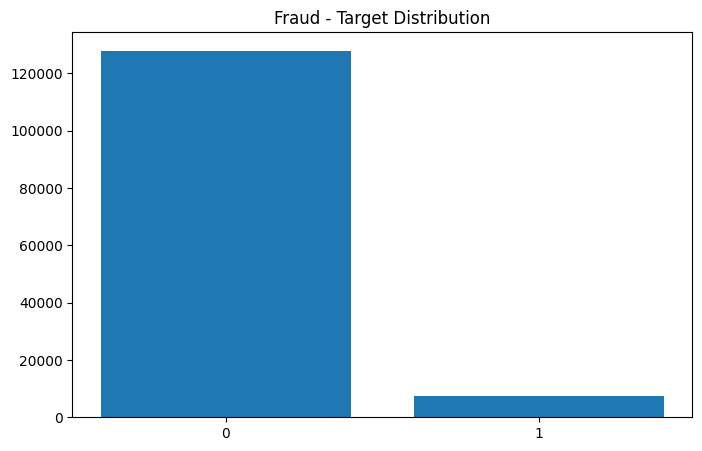

In [21]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

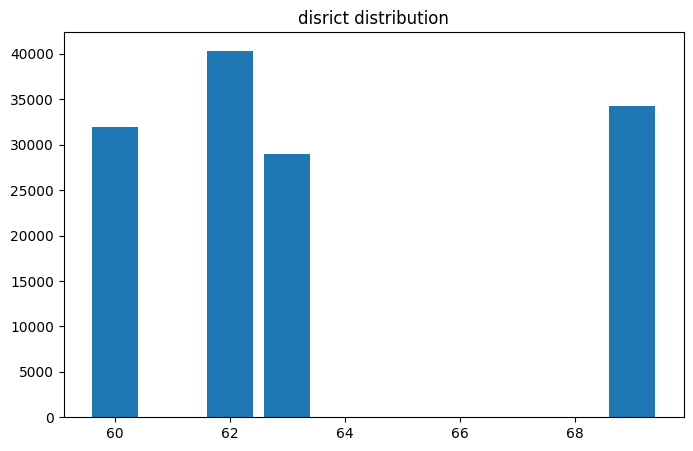

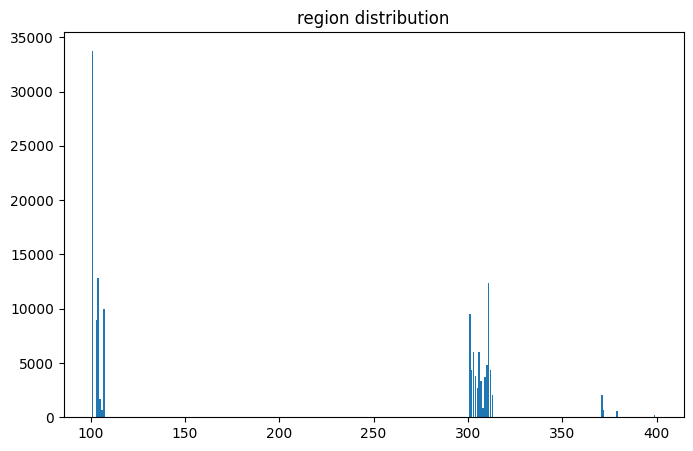

In [22]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

## Feature Engineering

In [23]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [24]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)

In [25]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

In [26]:
def aggregate_by_client_id(invoice_data):
    aggs = {} #define aggregation dictionary
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs) #invoice data is grouped by the client id and aggregated using the dict. aggs
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values] #new dataframe where each row represents a unique client_id and contains a mean of a consumption level specified
    #above the columns of agg_trans are renamed. This renaming concatenates the original column names (which are multi-level after the aggregation operation) into single-level column names by joining them with an underscore
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id') 
            .size()
            .reset_index(name='{}transactions_count'.format('1')))#we group the original invoice_data by client_id to count the number of transactions per client

    return pd.merge(df, agg_trans, on='client_id', how='left')#we merge the transaction count df with the counsumption level averages df agg_trans on client_id column

In [27]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)
#this will again compute the mean values of consommation_level_* grouped by client_id, rename the columns to consommation_level_*_mean, count the number of transactions for each client in invoce_data
#and merge these two sets of data (average consumption levels and transaction counts) into a single df

In [28]:
print(agg_train.shape)
agg_train.head()

(135493, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.40,10.57,0.00,0.00
1,train_Client_1,37,557.54,0.00,0.00,0.00
2,train_Client_10,18,798.61,37.89,0.00,0.00
3,train_Client_100,20,1.20,0.00,0.00,0.00
4,train_Client_1000,14,663.71,104.86,117.36,36.71


In [29]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')
train.head(10)

,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,60,train_Client_0,11,101,31/12/1994,0.00,35,352.40,10.57,0.00,0.00
1,69,train_Client_1,11,107,29/05/2002,0.00,37,557.54,0.00,0.00,0.00
2,62,train_Client_10,11,301,13/03/1986,0.00,18,798.61,37.89,0.00,0.00
3,69,train_Client_100,11,105,11/07/1996,0.00,20,1.20,0.00,0.00,0.00
4,62,train_Client_1000,11,303,14/10/2014,0.00,14,663.71,104.86,117.36,36.71
5,69,train_Client_10000,11,103,29/09/1993,0.00,48,352.10,10.44,3.77,0.00
6,62,train_Client_100000,11,309,07/06/2012,0.00,40,280.02,6.55,0.00,0.00
7,60,train_Client_100001,11,101,12/04/2006,0.00,78,327.50,0.92,0.00,0.00
8,62,train_Client_100002,11,301,31/12/2006,0.00,2,112.50,0.00,0.00,0.00
9,60,train_Client_100003,11,101,25/10/2011,0.00,5,850.80,"1,629.20",320.00,"4,882.00"


## Train - Test Split

In [30]:
#drop redundant columns
sub_client_id = train['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)

In [31]:
y = train['target']
X = train.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
X_train.shape, X_test.shape

((108394, 8), (27099, 8))

## Baseline

In [36]:
consumption_all = X_train.eval('consommation_level_1_mean + consommation_level_2_mean + consommation_level_3_mean + consommation_level_4_mean')
median_consumption = consumption_all.median()

# Generate binary predictions based on the median consumption
y_train_pred = (consumption_all > median_consumption).astype(int)

# For the test set, ensure to calculate the consumption sum using test set features
consumption_test = X_test.eval('consommation_level_1_mean + consommation_level_2_mean + consommation_level_3_mean + consommation_level_4_mean')
y_test_pred = (consumption_test > median_consumption).astype(int)

# Calculate metrics
metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}

metrics_df = pd.DataFrame(metrics, index=["Baseline"])
print(metrics_df)

          Accuracy  Recall  Precision  F1-score
Baseline      0.51    0.57       0.06      0.11


## LGBM Classifier

          Accuracy  Recall  Precision  F1-score
Baseline      0.94    0.03       0.18      0.05
Accuracy on training set: 0.95
Accuracy on test set: 0.94
----------------------------------------
Recall on training set: 0.11
Recall on test set: 0.01
----------------------------------------
Precision on training set: 1.0
Precision on test set: 0.31
----------------------------------------
fbeta_score on training set: 0.2
fbeta_score on test set: 0.02
----------------------------------------
roc_auc_score on trainig set:  0.9
roc_auc_score on test set:  0.74
----------------------------------------


(<Figure size 300x200 with 2 Axes>,
 <Axes: title={'center': 'Test Set'}, xlabel='Predicted label', ylabel='True label'>)

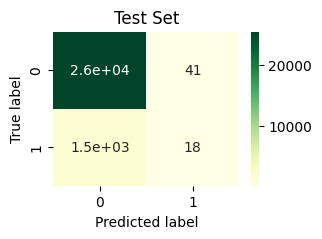

In [43]:
#model_lgbmc = LGBMClassifier(boosting_type='gbdt', num_iterations=500)

#model_lgbmc.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}


metrics_lgbmc = pd.DataFrame(metrics, index=["Baseline"])
print(metrics_lgbmc)

predict_and_print_scores(model_lgbmc, X_train, y_train, X_test, y_test)

## Log Reg
(Train LGBM *Classifier* at the end)

In [235]:
#y = train['target']
#X = train.drop('target', axis=1)

In [236]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

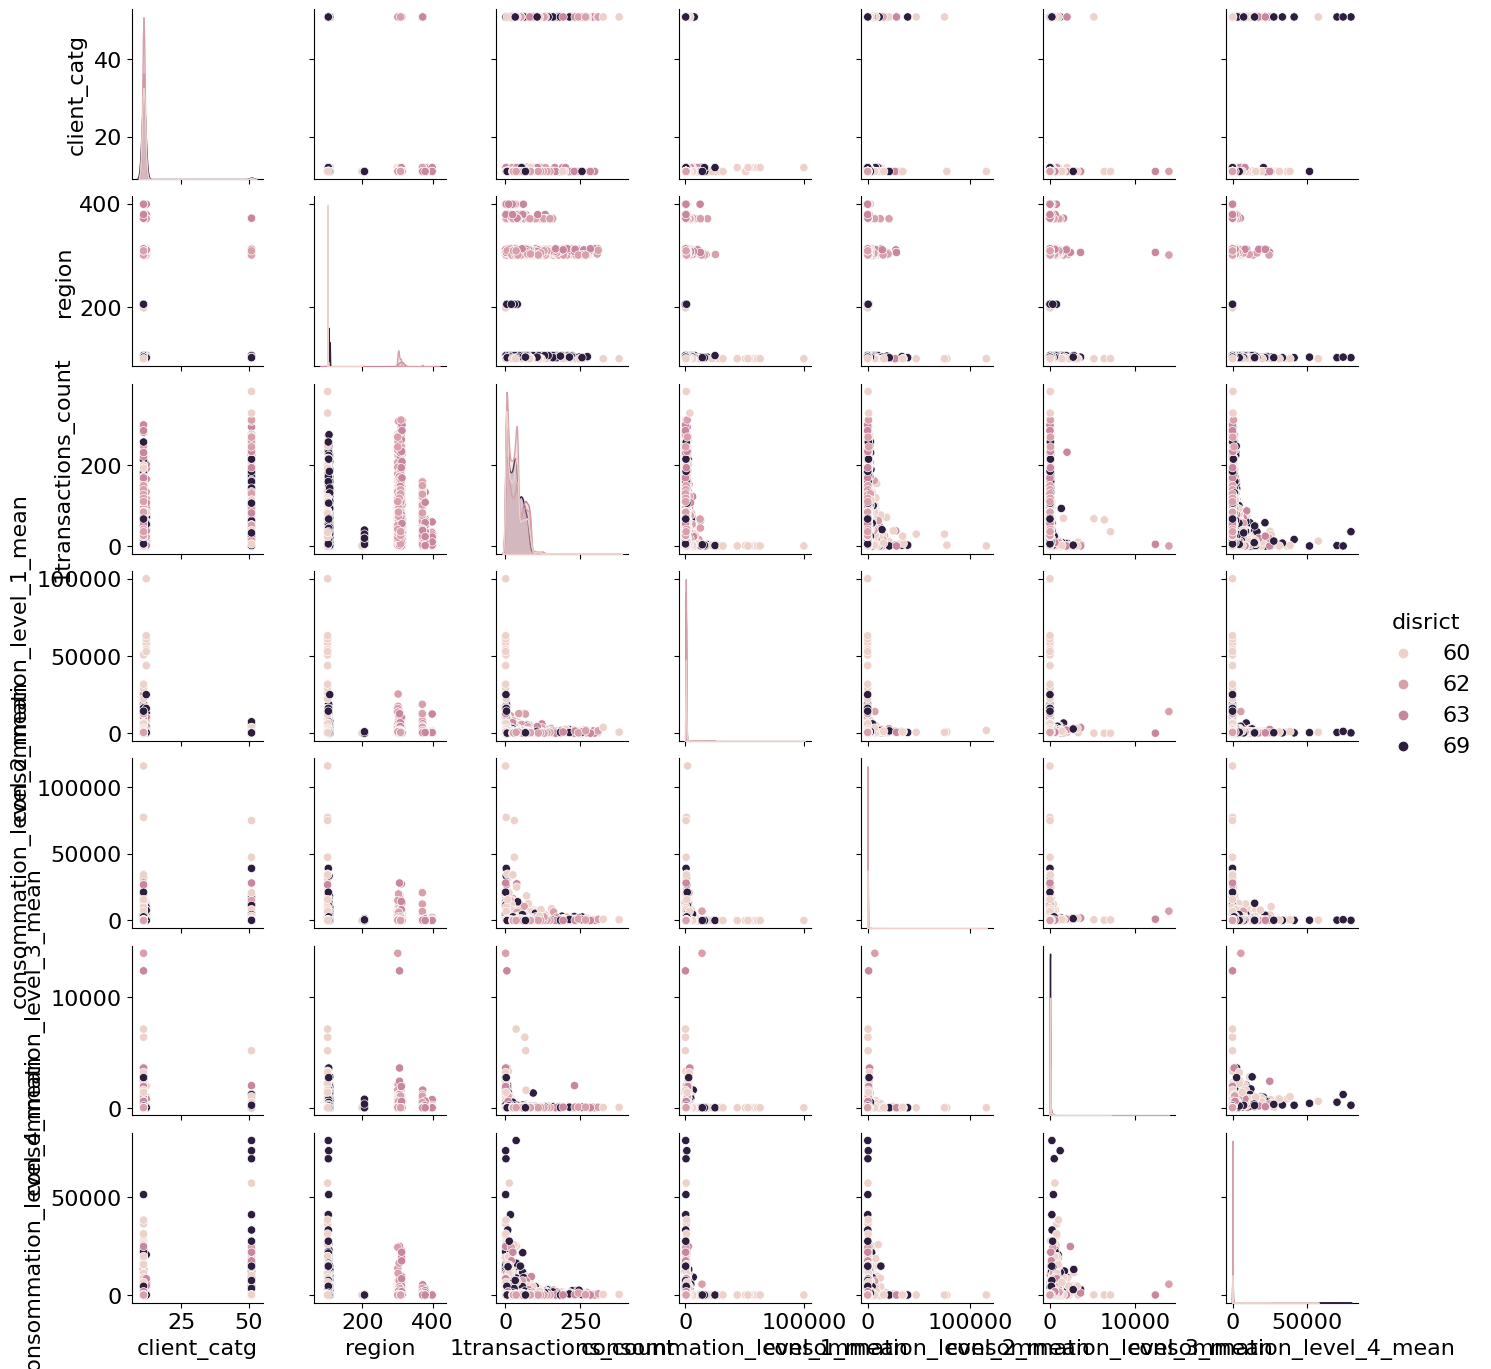

In [237]:
#sns.pairplot(X_train, hue="disrict", height=2,);

In [302]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns

# preprocessing for numerical columns
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# apply different preprocessing to num and cat features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

In [303]:
from imblearn.pipeline import Pipeline as Imbpipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [ ]:
#Evaluate model's performance through cross-validation 
logreg_pipeline = Imbpipeline(steps=[
    ('preprocessor', preprocessor),  # 1. preprocessing
    ('oversample', RandomOverSampler(sampling_strategy='minority')),  # 2. oversampling
    ('select', SelectKBest(score_func=mutual_info_classif, k='all')),
    ('logreg', LogisticRegression(max_iter=10000))
])

y_train_cv = cross_val_predict(logreg_pipeline, X_train, y_train, cv=5) # in order to get realistic estimate of the model's performance on unseen data, by using the existing data.

In [ ]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_cv)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_cv)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_cv)))

In [ ]:
logreg_pipeline.fit(X_train, y_train)

In [ ]:
y_test_pred = logreg_pipeline.predict(X_test)
#y_train_pred = logreg_pipeline.predict(X_train)

print("Accuracy with logreg (test): {:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall with logreg (test): {:.2f}".format(recall_score(y_test, y_test_pred)))
print("Precision with logreg (test): {:.2f}".format(precision_score(y_test, y_test_pred)))#how many of the transactions predicted as fraudulent are actually fraudulent
print("F1-score with logreg (test): {:.2f}".format(f1_score(y_test, y_test_pred)))

In [ ]:
metrics = {
    "Accuracy": [accuracy_score(y_test, y_test_pred)],
    "Recall": [recall_score(y_test, y_test_pred)],
    "Precision": [precision_score(y_test, y_test_pred)],
    "F1-score": [f1_score(y_test, y_test_pred)]
}

metrics_df = pd.DataFrame(metrics, index=["Logistic regression (test)"])
print(metrics_df)

In [ ]:
logreg_pipeline.score(X_test, y_test)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

fpr1, tpr1, thresholds1 = roc_curve(y_test, logreg_pipeline.predict_proba(X_test)[:,1])
auc1 = roc_auc_score(y_test, logreg_pipeline.predict_proba(X_test)[:,1])

base_fpr, base_tpr = [0, 1], [0, 1] 

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16

# Plot ROC curves
plt.plot(base_fpr, base_tpr, 'b', label = 'Baseline (random guessing)')
plt.plot(fpr1, tpr1, 'r', label = f'Model (AUC = {auc1:.2f})')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

In [247]:
#from lightgbm import LGBMClassifier

#model = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)
#model.fit(x_train, y_train)

In [248]:
#x_train.disrict.unique()

## Random Forest

In [249]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Imbpipeline(steps=[
    ('preprocessor', preprocessor),  # 1. preprocessing
    ('oversample', RandomOverSampler(sampling_strategy='minority')),  # 2. oversampling
    ('select', SelectKBest(score_func=mutual_info_classif, k='all')),
    ('rf', RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1))
])

rf_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['disrict', 'client_catg', 'region', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('oversample', RandomOverSampler(sampling_strategy='minority')),
                ('select',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x17fbd5f80>)),
                ('rf',
                 RandomForestClassifier(n_jobs=-1, random_state=42,
                                        verbose=1))])

In [250]:
y_test_pred = rf_pipeline.predict(X_test)
#y_train_pred = logreg_pipeline.predict(X_train)

print("Accuracy with rf (test): {:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall with rf (test): {:.2f}".format(recall_score(y_test, y_test_pred)))
print("Precision with rf (test): {:.2f}".format(precision_score(y_test, y_test_pred)))
print("F1-score with rf (test): {:.2f}".format(f1_score(y_test, y_test_pred)))

Accuracy with rf (test): 0.93
Recall with rf (test): 0.04
Precision with rf (test): 0.15
F1-score with rf (test): 0.07


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


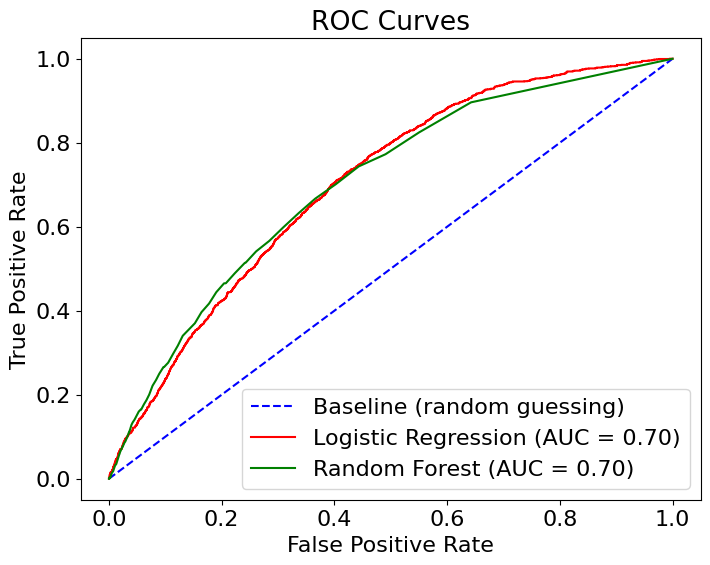

In [251]:
fpr2, tpr2, thresholds2 = roc_curve(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
auc2 = roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1])

# Existing code for logistic regression model and baseline
fpr1, tpr1, thresholds1 = roc_curve(y_test, logreg_pipeline.predict_proba(X_test)[:, 1])
auc1 = roc_auc_score(y_test, logreg_pipeline.predict_proba(X_test)[:, 1])

base_fpr, base_tpr = [0, 1], [0, 1]

plt.figure(figsize=(8, 6))
plt.rcParams['font.size'] = 16

# Plot ROC curves
plt.plot(base_fpr, base_tpr, 'b', linestyle='--', label='Baseline (random guessing)')
plt.plot(fpr1, tpr1, 'r', label=f'Logistic Regression (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, 'g', label=f'Random Forest (AUC = {auc2:.2f})')  # New curve for rf_pipeline

plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

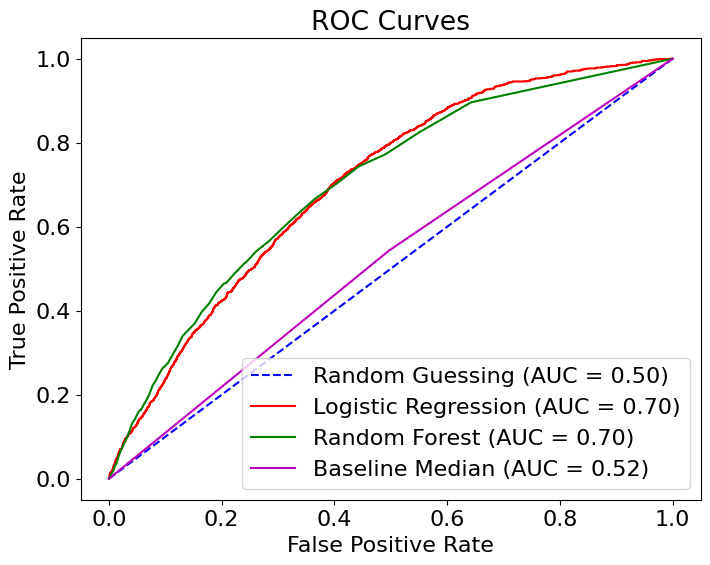

In [252]:
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming y_true and y_pred are defined as shown previously
fpr_base, tpr_base, _ = roc_curve(y_true, y_pred)
auc_base = roc_auc_score(y_true, y_pred)

# Now, include this baseline in your ROC curve plot
plt.figure(figsize=(8, 6))
plt.rcParams['font.size'] = 16

# Plot ROC curves
plt.plot(base_fpr, base_tpr, 'b', linestyle='--', label='Random Guessing (AUC = 0.50)')
plt.plot(fpr1, tpr1, 'r', label=f'Logistic Regression (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, 'g', label=f'Random Forest (AUC = {auc2:.2f})')
plt.plot(fpr_base, tpr_base, 'm', label=f'Baseline Median (AUC = {auc_base:.2f})')  # Adding the baseline to the plot

plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()


In [253]:
import xgboost as xgb

In [254]:
#Evaluate model's performance through cross-validation 
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',  # to avoid warning since default evaluation metric will change in future versions of XGBoost
    random_state=42
)


xgb_pipeline = Imbpipeline(steps=[
    ('preprocessor', preprocessor),  # 1. preprocessing
    ('oversample', RandomOverSampler(sampling_strategy='minority')),  # 2. oversampling
    ('select', SelectKBest(score_func=mutual_info_classif, k='all')),
    ('xgb', xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',  # to avoid warning since default evaluation metric will change in future versions of XGBoost
    random_state=42
))
])

#y_train_cv = cross_val_predict(xgb_pipeline, X_train, y_train, cv=5) # in order to get realistic estimate of the model's performance on unseen data, by using the existing data.

In [255]:
xgb_pipeline.fit(X_train, y_train)

y_pred = xgb_pipeline.predict(X_test)
y_pred_proba = xgb_pipeline.predict_proba(X_test)[:,1]  # For AUC calculation

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUC: {auc:.2f}')

Accuracy: 0.66
Recall: 0.70
Precision: 0.11
F1 Score: 0.19
AUC: 0.75


In [256]:
select_k_best = xgb_pipeline.named_steps['select']
selected_features = select_k_best.get_support(indices=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


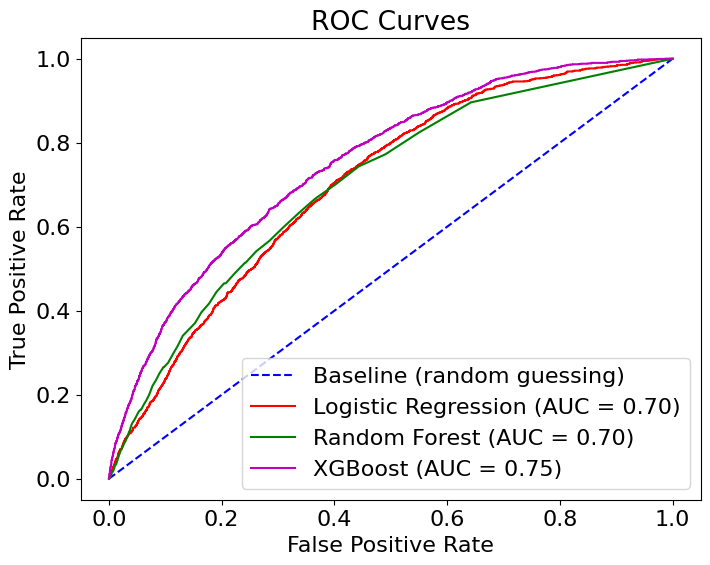

In [257]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_pipeline.predict_proba(X_test)[:, 1])
auc_xgb = roc_auc_score(y_test, xgb_pipeline.predict_proba(X_test)[:, 1])

fpr1, tpr1, thresholds1 = roc_curve(y_test, logreg_pipeline.predict_proba(X_test)[:, 1])
auc1 = roc_auc_score(y_test, logreg_pipeline.predict_proba(X_test)[:, 1])

fpr2, tpr2, thresholds2 = roc_curve(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
auc2 = roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1])

base_fpr, base_tpr = [0, 1], [0, 1]

plt.figure(figsize=(8, 6))
plt.rcParams['font.size'] = 16

plt.plot(base_fpr, base_tpr, 'b', linestyle='--', label='Baseline (random guessing)')
plt.plot(fpr1, tpr1, 'r', label=f'Logistic Regression (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, 'g', label=f'Random Forest (AUC = {auc2:.2f})')
plt.plot(fpr_xgb, tpr_xgb, 'm', label=f'XGBoost (AUC = {auc_xgb:.2f})')  # Adding the XGBoost model

plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

## Make Predictions on test set

In [258]:
test.columns

Index(['disrict', 'client_catg', 'region', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean'],
      dtype='object')

In [259]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

NotFittedError: need to call fit or load_model beforehand

In [ ]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

In [ ]:
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************